In [1]:
from utils.all import *

# There's also 'tutorial' and 'preliminary' data
data = load_data('../annotated', batch_num=[5, 6, 7, 8, 9, 10, 11], preprocess=True) # batch_num=1,

Loading files: ['../annotated/batch_5_anton.json', '../annotated/batch_5_ayush.json', '../annotated/batch_5_kelly.json', '../annotated/batch_5_rachel.json', '../annotated/batch_5_vinayak.json', '../annotated/batch_5_vishnesh.json', '../annotated/batch_6_anton.json', '../annotated/batch_6_ayush.json', '../annotated/batch_6_kelly.json', '../annotated/batch_6_rachel.json', '../annotated/batch_6_vinayak.json', '../annotated/batch_6_vishnesh.json', '../annotated/batch_7_anton.json', '../annotated/batch_7_ayush.json', '../annotated/batch_7_kelly.json', '../annotated/batch_7_rachel.json', '../annotated/batch_7_vinayak.json', '../annotated/batch_7_vishnesh.json', '../annotated/batch_8_anton.json', '../annotated/batch_8_ayush.json', '../annotated/batch_8_kelly.json', '../annotated/batch_8_rachel.json', '../annotated/batch_8_vinayak.json', '../annotated/batch_8_vishnesh.json', '../annotated/batch_9_ayush.json', '../annotated/batch_9_kelly.json', '../annotated/batch_9_rachel.json', '../annotated/

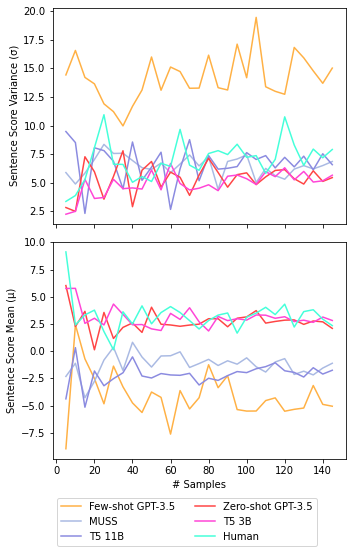

In [2]:
import numpy as np
import random

cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100
std = lambda x: np.std(random.choices(x, k=1000), ddof=1)
mean = lambda x: np.mean(random.choices(x, k=1000))


# Calculates CV sampling different numbers of sentences
# We find the CV stablizes with enough annotations, but a 'stable' CV is simply directly
# a function of more data

# CV measure the 'spread' of data. A tigher distribution has a higher CV. Although we suppose
# simplification itself must have some observed varaiation, so the goal here is not to minimize
# the CV.

step = 5
fig, ax = plt.subplots(2, 1, figsize=(5, 7), sharex=True)

selected_systems = list(set([sent['system'] for sent in data if 'Human' not in sent['system']])) + ['aggregated/human']

# Uncomment to exclude T5 and MUSS
# selected_systems = [s for s in selected_systems if 'Muss' not in s and 'T5' not in s]

measures = [std, mean]

for i, measure in enumerate(measures):
    for system in [s for s in systems if s in selected_systems]:
        pts = []

        # todo: combine human

        selected = [sent for sent in data if sent['system'] == system]
        if system == 'aggregated/human':
            selected = [sent for sent in data if 'Human' in sent['system']]

        for amt in range(step, 150, step): # len(selected)
            pts += [(amt, measure(random.sample([sent['score'] for sent in selected], amt)))] # range(1000)

        x, y = zip(*pts)
        ax[i].plot(x, y, linestyle="-", marker="", label=system_name_mapping[system], color=color_mapping[system])

fig.legend(
    selected_systems, 
    labels=[system_name_mapping[s] for s in selected_systems], 
    loc='lower center', ncol=2, bbox_to_anchor=(0.53, -0.1))
# ax[0].set_xticks([])
ax[1].set_xlabel("# Samples")

ax[0].set_ylabel("Sentence Score Variance (σ)")
ax[1].set_ylabel("Sentence Score Mean (µ)")

# TODO: Force y-axis integers

out_filename = "img/analytical-stability.pdf"
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)

plt.show()

In [3]:
# Show the agreement with SimpEval
# simpeval_agreement(data)

In [4]:
sent = [sent for sent in data if sent['batch'] == 5 and sent['hit_id'] == 11 and sent['user'] == 'vishnesh'][0]
get_sent_info(sent)

'vishnesh - Batch 5, HIT 12 (ID 6)'

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

def token_level_disagreement(data, collapse_composite=False, majority_disagreement=False):
    total_agreement = []
    MAX_HIT = max([x['id'] for x in data])+1
    for sent_id in range(0, MAX_HIT):
        sents = [x for x in data if x['id'] == sent_id]
        orig_tokens = get_annotations_per_token(sents, 'original', collapse_composite=collapse_composite)
        simp_tokens = get_annotations_per_token(sents, 'simplified', collapse_composite=collapse_composite)

        arr_edits = []
        for edits in list(orig_tokens.values()) + list(simp_tokens.values()):
            out = []
            for k, v in edits.items():
                for amt in range(v):
                    out += [k]
            for i in range(3 - len(out)):
                out += [None]
            arr_edits += [out]

        if majority_disagreement:
            # This takes edits with a 2 agreeing annotators and 1 disagreeing annotator
            # and reports agreement between the majority and minority classes
            disagreement = []
            for edit in arr_edits:
                majority, minority = None, None
                if edit[0] == edit[1]:
                    majority = edit[0]
                    minority = edit[2]
                elif edit[1] == edit[2]:
                    majority = edit[1]
                    minority = edit[0]
                elif edit[0] == edit[2]:
                    majority = edit[0]
                    minority = edit[1]
                
                if majority is None or minority is None or majority == minority:
                    continue
            
                disagreement += [[majority, minority]]
        else:
            # This replicates each edit and calculates pairwise agreement
            # [A1, A2]
            # [A2, A3]
            # [A3, A1]
            interwoven = []
            for edit in arr_edits:
                interwoven += [[edit[0], edit[1]]]
                interwoven += [[edit[1], edit[2]]]
                interwoven += [[edit[0], edit[2]]]
            
            disagreement = []
            for edit in interwoven:
                # Important point, could be 'or'
                if edit[0] is None or edit[1] is None:
                    continue
                # Cannot display agreement
                if edit[0] == edit[1]:
                    continue
                disagreement += [edit]

        total_agreement += disagreement
    return total_agreement

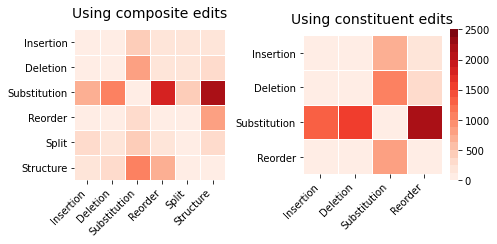

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3.5)) #sharex=True, sharey=True)

vmin, vmax = 0, 2500

color_bar = sn.color_palette("Reds", 20)

# Change label ordering
edit_type_labels = ['insertion', 'deletion', 'substitution', 'reorder', 'split', 'structure']

disagreement = token_level_disagreement(data)
a = confusion_matrix([x[0] for x in disagreement], [x[1] for x in disagreement], labels=edit_type_labels)
df_cm = pd.DataFrame(a, index=[x.capitalize() for x in edit_type_labels], columns=[x.capitalize() for x in edit_type_labels])
sn.heatmap(df_cm, cmap=color_bar, ax=ax1, vmin=vmin, vmax=vmax, square=True, cbar=False, linewidth=.5)

disagreement = token_level_disagreement(data, collapse_composite=True)
a = confusion_matrix([x[0] for x in disagreement], [x[1] for x in disagreement], labels=[x for x in edit_type_labels if x not in ['structure', 'split']])
df_cm = pd.DataFrame(a, index=[x.capitalize() for x in edit_type_labels if x not in ['structure', 'split']], columns=[x.capitalize() for x in edit_type_labels if x not in ['structure', 'split']])
sn.heatmap(df_cm, cmap=color_bar, ax=ax2, vmin=vmin, vmax=vmax, square=True, linewidth=.5)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha="right")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha="right")

ax1.set_title('Using composite edits', pad=12, fontsize=14)
ax2.set_title('Using constituent edits', pad=12, fontsize=14)

fig.tight_layout()

out_filename = "img/agreement-heatmap.pdf"
plt.savefig(out_filename, format="pdf", bbox_inches='tight', pad_inches=0.0)

plt.show()

In [7]:
# Confusion matrix of different types of errors.
# Entry at row i, column j corresponds to the frequency
# of annotations that have Fi as the majority class and for
# which disagreeing annotator selected Fj.


# Instead calculate agreement using split & strucure's composite edits
# Change color scheme
# Remove numbers

# FRANK paper had the "majority class" as 1 axis and the "minority class" as 
# another axis. Redo code to show that instead. Write this in paper

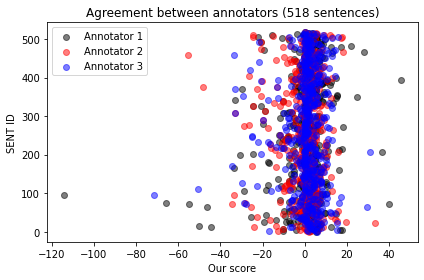

In [8]:
# Calculate the inter-annotator agreement on sentence-level scores
final = []
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    scores = [x['score'] for x in sents]
    
    # Delete this: if not all scores are present, skip this sentence
    if len(scores) != 3:
        continue
    
    final.append(scores)

# Plot the scores for each sentence
ann_mapping = {
    0: 'black',
    1: 'red',
    2: 'blue'
}
for ann in range(0, 3):
    pts = [(i, score) for i, score in enumerate([x[ann] for x in final])]
    plt.scatter([p[1] for p in pts], [p[0] for p in pts], c=ann_mapping[ann], alpha=0.5, label=f'Annotator {ann+1}')
plt.xlabel('Our score')
plt.ylabel('SENT ID')
plt.title(f'Agreement between annotators ({len(pts)} sentences)')
plt.rcParams["figure.figsize"] = (10, 5)
plt.legend()
plt.show()

In [9]:
# Calculates Rough Span Agreement Score
# TODO: Does not work for multiple batches
total_agreement = []
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    orig_tokens = get_annotations_per_token(sents, 'original')
    simp_tokens = get_annotations_per_token(sents, 'simplified')
    agg_score = 0
    for val in list(orig_tokens.values()) + list(simp_tokens.values()):
        agg_score += (list(val.values())[0] - 3)
    total_agreement.append(agg_score)
print(f"Sent with full agreement {sum([x == 0 for x in total_agreement])} / {MAX_HIT}")
# hds = sorted([(i, val) for i, val in enumerate(total_agreement)], key=lambda x: x[1])
# print("\nHighest disagreement sentences:")
# for x in [get_sent_info(data[x[0]]) for x in hds][:5]:
#     print(x)

Sent with full agreement 69 / 695


In [10]:
# The problem right now is most disagreement is between structure and other changes
# However structure is a composite of other changes. So is it really *span* selection?
# We count structure twice. Once as a span itself, and once as each of its composite spans
# Hopefully agreement goes up? Might not...

In [11]:
# First need to add a new field to structure edits containing its composite edits. Basically just needs the spans and type
# Then, in the function, we modify the edits array to also include the composite edits.

{(5, 11): {'substitution': 3},
 (32, 39): {'substitution': 2, 'structure': 1},
 (40, 45): {'structure': 1},
 (46, 48): {'substitution': 2, 'structure': 2},
 (49, 55): {'substitution': 2, 'structure': 2},
 (85, 88): {'split': 3, 'deletion': 1},
 (97, 104): {'substitution': 3},
 (120, 123): {'substitution': 2},
 (124, 131): {'substitution': 2},
 (132, 140): {'substitution': 2}}

{(5, 9): {'substitution': 3},
 (30, 35): {'substitution': 2, 'structure': 1},
 (36, 41): {'structure': 1},
 (42, 50): {'substitution': 2, 'structure': 2},
 (80, 82): {'split': 3},
 (83, 85): {'split': 3, 'insertion': 1},
 (86, 90): {'split': 2, 'insertion': 1},
 (91, 93): {'split': 2, 'insertion': 1},
 (94, 99): {'split': 2, 'insertion': 1},
 (109, 113): {'substitution': 3},
 (129, 137): {'substitution': 2}}

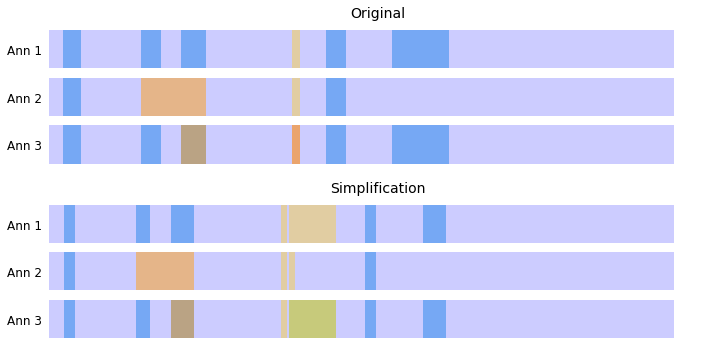

In [12]:
HID_ID = 12
sents = [x for x in data if x['id'] == HID_ID]
orig_tokens = get_annotations_per_token(sents, 'original')
simp_tokens = get_annotations_per_token(sents, 'simplified')

display(orig_tokens)
display(simp_tokens)
draw_agreement(sents, paper=True)

In [13]:
data[0]['edits']

[{'type': 'deletion',
  'id': 0,
  'original_span': [(92, 95)],
  'simplified_span': None,
  'annotation': ['perfect', 'no', 'no']},
 {'type': 'deletion',
  'id': 1,
  'original_span': [(113, 124)],
  'simplified_span': None,
  'annotation': ['good', 'no', 'no']},
 {'type': 'deletion',
  'id': 2,
  'original_span': [(287, 310)],
  'simplified_span': None,
  'annotation': ['perfect', 'no', 'no']},
 {'type': 'substitution',
  'id': 0,
  'original_span': [(229, 234)],
  'simplified_span': [(231, 234)],
  'annotation': ['same', 'positive', 'a lot', '', 'no']},
 {'type': 'substitution',
  'id': 1,
  'original_span': [(235, 244)],
  'simplified_span': [(235, 245)],
  'annotation': ['same', 'no', '', '', 'no']},
 {'type': 'substitution',
  'id': 2,
  'original_span': [(245, 247)],
  'simplified_span': [(246, 248)],
  'annotation': ['same', 'positive', 'somewhat', '', 'no']},
 {'type': 'substitution',
  'id': 3,
  'original_span': [(318, 322)],
  'simplified_span': [(296, 305)],
  'annotation'

In [56]:
def get_second_order_annotations_per_token(sents, sent_type, remove_none=True):
    edit_dict_value = sent_type + '_span'
    tokens = generate_token_dict(sents[0][sent_type])
    
    # Iterate through all annotators' edits
    for sent in sents:
        edits = sent['edits']
        
        for edit in edits:
            if edit[edit_dict_value] is None:
                continue

            for elongated_span in edit[edit_dict_value]:
                composite_spans = [
                    (entry[0] + elongated_span[0], entry[1] + elongated_span[0]) 
                    for entry in list(
                        generate_token_dict(sents[0][sent_type][elongated_span[0]:elongated_span[1]]).keys()
                    )
                ]

                for c_span in composite_spans:
                    if c_span in tokens.keys():                       
                        type_ = edit['type']

                        # Extract subtype from edit entry
                        if type_ == 'substitution':
                            subtype = edit['annotation'][0]
                            if subtype == 'more':
                                type_ = 'elaboration_substitution'
                            elif subtype == 'less':
                                type_ = 'generalization_substitution'
                            elif subtype == 'same':
                                type_ = 'paraphrasing_substitution'
                            elif subtype == 'different':
                                type_ = 'paraphrasing_different'
                            else:
                                print(edit)
                        elif type_ == 'reorder':
                            subtype = edit['annotation'][-1]
                            if subtype == 'word':
                                type_ = 'word_reorder'
                            elif subtype == 'component':
                                type_ = 'component_reorder'
                            else:
                                continue
                            # If the annotator does not specify, we skip

                        # Increment the edit type
                        if type_ not in tokens[c_span].keys():
                            tokens[c_span][type_] = 0
                        tokens[c_span][type_] += 1
                    elif c_span is None:
                        pass
                    else:
                        print(edit)
                        print("there's a problem boss")
    
    # Remove spans with no annotations from any annotator
    if remove_none:
        keys = list(tokens.keys())
        for entry in keys:
            if len(tokens[entry].keys()) == 0:
                del tokens[entry]
    return tokens

In [57]:
sents = [x for x in data if x['id'] == 1]
get_second_order_annotations_per_token(sents, 'original')

# substitution - elaboration, generalization
# reorder - word-level, component-level
# substitution - paraphrasing

# Calculates % Agreement
total_agreement = []
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    orig_tokens = get_second_order_annotations_per_token(sents, 'original')
    simp_tokens = get_second_order_annotations_per_token(sents, 'simplified')
    total_agreement += list(orig_tokens.values()) + list(simp_tokens.values())

span_agreement = {}
agreement_dims = [
    'insertion', 
    'deletion', 
    'elaboration_substitution',
    'generalization_substitution',
    'paraphrasing_substitution',
    'word_reorder',
    'component_reorder', 
    'split', 
    'structure'
]

for edit_type in agreement_dims:
    out = {
        3: 0,
        2: 0,
        1: 0
    }
    for d in total_agreement:
        if edit_type in d.keys():
            if d[edit_type] not in out.keys():
                out[d[edit_type]] = 0
            out[d[edit_type]] += 1
    total = sum(out.values())
    # Avoid division by 0, doesn't change calculation at all
    total = 1 if total == 0 else total
    # print(f'{edit_type}: {int(100*out[3]/total)} {int(100*out[2]/total)} {int(100*out[1]/total)}')
    span_agreement[edit_type] = {
        'three': int(100*out[3]/total),
        'two': int(100*out[2]/total)
    }
span_agreement

{'insertion': {'three': 13, 'two': 27},
 'deletion': {'three': 37, 'two': 27},
 'elaboration_substitution': {'three': 2, 'two': 10},
 'generalization_substitution': {'three': 6, 'two': 20},
 'paraphrasing_substitution': {'three': 19, 'two': 31},
 'word_reorder': {'three': 0, 'two': 11},
 'component_reorder': {'three': 9, 'two': 28},
 'split': {'three': 29, 'two': 28},
 'structure': {'three': 5, 'two': 20}}

In [59]:
from sklearn.metrics import cohen_kappa_score
import krippendorff
from statsmodels.stats.inter_rater import fleiss_kappa
from statsmodels.stats import inter_rater as irr

for edit in agreement_dims:
    total_agreement = None
    MAX_HIT = max([x['id'] for x in data])+1
    for sent_id in range(0, MAX_HIT):
        sents = [x for x in data if x['id'] == sent_id]
        final = []
        for sent in sents:
            tokens_orig = get_second_order_annotations_per_token([sent], 'original', remove_none=False)
            tokens_simp = get_second_order_annotations_per_token([sent], 'simplified', remove_none=False)
            all_edits = list(tokens_orig.values()) + list(tokens_simp.values())
            formatted = []
            for edits in all_edits:
                if edit in edits.keys():
                    formatted += [1]
                else:
                    formatted += [0]
                # formatted += [nx]
            final += [formatted]
        
        if len(sents) == 3:
            if total_agreement is None:
                total_agreement = np.asarray(final)
            else:
                total_agreement = np.append(total_agreement, np.asarray(final), axis=1)
    
    # Delete columns with all 0s
    # idx = np.argwhere(np.all(total_agreement[..., :] == 0, axis=0))
    # total_agreement = np.delete(total_agreement, idx, axis=1)

    
    value_counts = total_agreement
    print(f"{edit} ({total_agreement.shape[1]} tokens)")
    # Having trouble formatting the krippendorff alpha
    # print(krippendorff.alpha(value_counts=value_counts, level_of_measurement='nominal'))
    print(cohen_kappa_score(total_agreement[0, :], total_agreement[1, :]))
    print(cohen_kappa_score(total_agreement[1, :], total_agreement[2, :]))
    print(cohen_kappa_score(total_agreement[0, :], total_agreement[2, :]))
    agg = irr.aggregate_raters(total_agreement.T)
    agg_fleiss = irr.fleiss_kappa(agg[0], method='fleiss')
    print(agg_fleiss, end='\n\n')

    span_agreement[edit]['fleiss'] = agg_fleiss

insertion (36332 tokens)
0.45903075014793937
0.5053943642016249
0.44295211057275385
0.47114643052925925

deletion (36332 tokens)
0.7564395828462225
0.7447597034558463
0.7622513615671267
0.7543277356185704

elaboration_substitution (36332 tokens)
0.19776852212969886
0.1799603981714475
0.09984391632609246
0.15673957547135808

generalization_substitution (36332 tokens)
0.2707475861494435
0.39028201553228725
0.34153489871644116
0.333307450334642

paraphrasing_substitution (36332 tokens)
0.5350314911182439
0.548502983610484
0.5513611753451129
0.5447209639927365

word_reorder (36332 tokens)
0.12345914752665943
0.08287329161850154
0.014556083707826795
0.07968423673296358

component_reorder (36332 tokens)
0.46551916027386675
0.3617622520252961
0.3779444203255119
0.4002157612484546

split (36332 tokens)
0.6234194568745375
0.6973632254698152
0.7249123132400375
0.681607678959448

structure (36332 tokens)
0.2222008448066386
0.31644497033897934
0.23137724821196815
0.25733124316415695



In [60]:
table_edit_type_mapping = {
    'insertion': '\\midrule\n\\ei{Insertion} & Elaboration', 
    'deletion': '\\ed{Deletion} & Generalization', 
    # 'substitution': '\\es{Substitution}', 
    'elaboration_substitution': '\\es{Substitution} & Elaboration',
    'generalization_substitution': ' & Generalization',
    # 'reorder': '\\er{Reorder}', 
    'word_reorder': '\\midrule\n\\er{Reorder} & Word-level',
    'component_reorder': ' & Component-level',
    'split': '\\esp{Split} & Sentence Split', 
    'structure': '\\est{Structure} & Structure',
    'paraphrasing_substitution': '\\midrule\n\\es{Substitution} & Paraphrase'
}
table = ''
for edit_type in table_edit_type_mapping.keys():
    table += f'{table_edit_type_mapping[edit_type]} & {round(span_agreement[edit_type]["fleiss"], 2)} & {span_agreement[edit_type]["three"]} & {span_agreement[edit_type]["two"]} \\\\\n'

print(table)

\midrule
\ei{Insertion} & Elaboration & 0.47 & 13 & 27 \\
\ed{Deletion} & Generalization & 0.75 & 37 & 27 \\
\es{Substitution} & Elaboration & 0.16 & 2 & 10 \\
 & Generalization & 0.33 & 6 & 20 \\
\midrule
\er{Reorder} & Word-level & 0.08 & 0 & 11 \\
 & Component-level & 0.4 & 9 & 28 \\
\esp{Split} & Sentence Split & 0.68 & 29 & 28 \\
\est{Structure} & Structure & 0.26 & 5 & 20 \\
\midrule
\es{Substitution} & Paraphrase & 0.54 & 19 & 31 \\



In [18]:
# Calculates agreement for errors
error = Error.BAD_DELETION

def get_error_stats(error):
    total_agreement = None
    MAX_HIT = max([x['id'] for x in data])+1
    for sent_id in range(0, MAX_HIT):
        sents = [x for x in data if x['id'] == sent_id]

        sents_errors = []
        for sent in sents:
            errors = []
            for ann in sent['processed_annotations']:
                if (error.value == 'grammar_error' and ann['grammar_error']) or ann['error_type'] == error:
                    errors += [1]
                else:
                    errors += [0]
            sents_errors += [1 if any(errors) == True else 0]

        # Converts error array to 0/1 mapping using alphabetical ordering
        if len(sents_errors) == 3:
            if total_agreement is None:
                total_agreement = np.asarray([sents_errors])
            else:
                total_agreement = np.append(total_agreement, np.asarray([sents_errors]), axis=0)

    if total_agreement.sum() == 0:
        print(f'No {error.value} errors', end='\n\n')
        return None

    stats = {}
    agg = irr.aggregate_raters(total_agreement)
    stats['fleiss'] = irr.fleiss_kappa(agg[0], method='fleiss')

    # Delete columns with all 0s
    total_agreement = total_agreement.T
    idx = np.argwhere(np.all(total_agreement[..., :] == 0, axis=0))
    total_agreement = np.delete(total_agreement, idx, axis=1)
    total_agreement = total_agreement.T

    # % two agree
    two_agree = []
    for entry in total_agreement:
        two_agree.append(np.sum(entry) >= 2)
    stats['two'] = 100*sum(two_agree) / total_agreement.shape[0]

    # % frequency
    stats['freq'] = 100*len(total_agreement) / MAX_HIT

    return stats

class Tmp(Enum):
    GRAMMAR_ERROR = 'grammar_error'

table = ''
all_stats = {}
for error in [e for e in Error] + [Tmp.GRAMMAR_ERROR]:
    stats = get_error_stats(error)
    if stats is not None:
        all_stats[error] = stats

sorted_stats = sorted([(k, v['freq']) for k, v in all_stats.items()], key=lambda x: x[1], reverse=True)

for error in [x[0] for x in sorted_stats]:
    table += f'{error.value} & {round(all_stats[error]["fleiss"], 2)} & {int(all_stats[error]["two"])} & {int(all_stats[error]["freq"])} \\\\ \n'
table = table.replace('grammar_error', 'Grammar Error')

print(table)

No Hallucination errors

No Unnecessary Insertion errors

Bad Deletion & 0.51 & 64 & 35 \\ 
Complex Wording & 0.26 & 32 & 20 \\ 
Information Rewrite & 0.27 & 26 & 10 \\ 
Grammar Error & 0.17 & 18 & 10 \\ 
Bad Structure & 0.02 & 6 & 10 \\ 
Bad Reorder & 0.14 & 19 & 9 \\ 
Irrelevant & 0.22 & 26 & 8 \\ 
Bad Split & 0.13 & 17 & 4 \\ 
Repetition & 0.33 & 30 & 4 \\ 
Contradiction & 0.19 & 25 & 1 \\ 
Coreference & -0.0 & 0 & 0 \\ 



In [41]:
from scipy.stats import kendalltau
from scipy.stats import pearsonr
import krippendorff

# Calculates sentence-score agreement
total_agreement = None
MAX_HIT = max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    scores = [sent['score'] for sent in sents]
    if len(scores) == 3:
        if total_agreement is None:
            total_agreement = np.asarray([scores])
        else:
            total_agreement = np.append(total_agreement, np.asarray([scores]), axis=0)

tau, p_value = kendalltau(total_agreement[:, 1], total_agreement[:, 2])
r, p_value = pearsonr(total_agreement[:, 1], total_agreement[:, 2])
kd = krippendorff.alpha(reliability_data=total_agreement[:300, :].T, level_of_measurement='interval')
print(tau)
print(r)
print(kd)

0.28988587526825904
0.48605516267217225
0.49022579894023255


In [20]:
# Some examples of high disagreement
# This isn't the correct way to calculate disagreement between the scores
# high_disagreement = [y[1] for y in sorted([(abs(x[0] - x[1]), i) for i, x in enumerate(scores) if x[0] != 0], reverse=True)][:5]
# for idx in high_disagreement:
#     example = data[idx]
#     print(f'HIT {example["id"] + 1}\nAnnotator: {example["user"]}\nSimpEval Score: {example["simpeval_scores"]}\nOur Score: {example["score"]}\nSystem: {system_name_mapping[example["system"]]}\n')

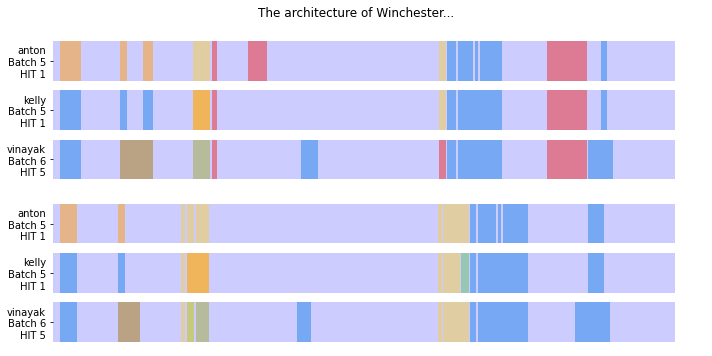

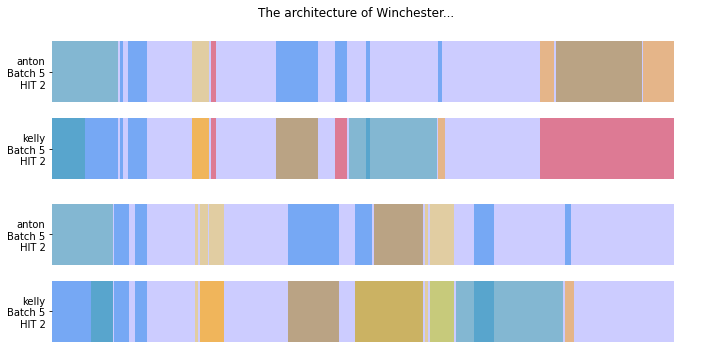

In [21]:
# Display the agreeement on all sentences
MAX_HIT = 2 # max([x['id'] for x in data])+1
for sent_id in range(0, MAX_HIT):
    sents = [x for x in data if x['id'] == sent_id]
    draw_agreement(sents)

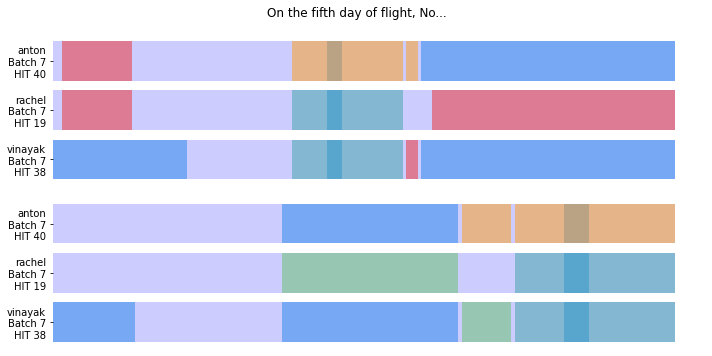

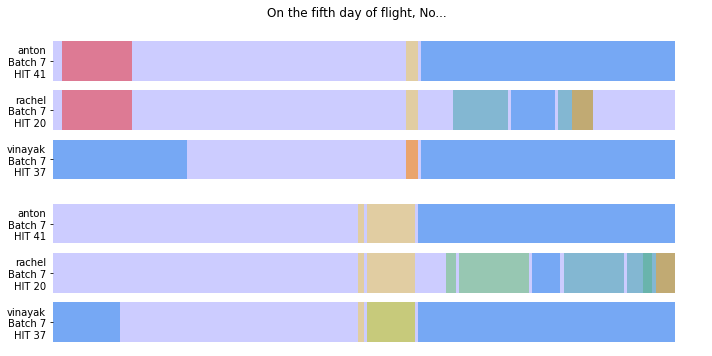

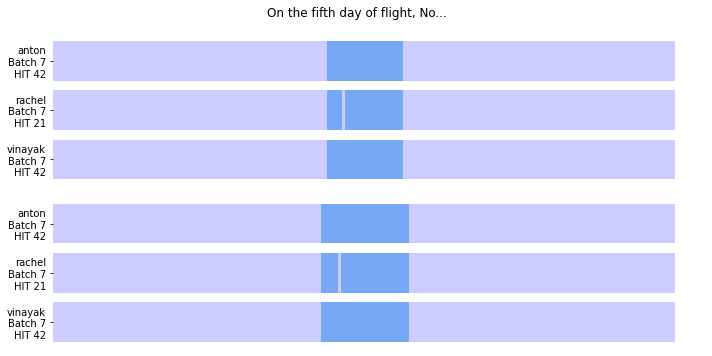

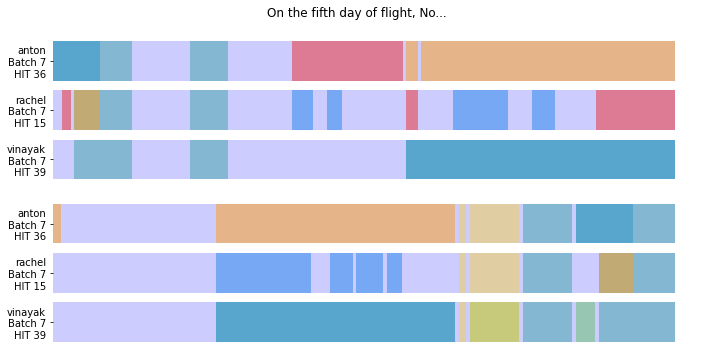

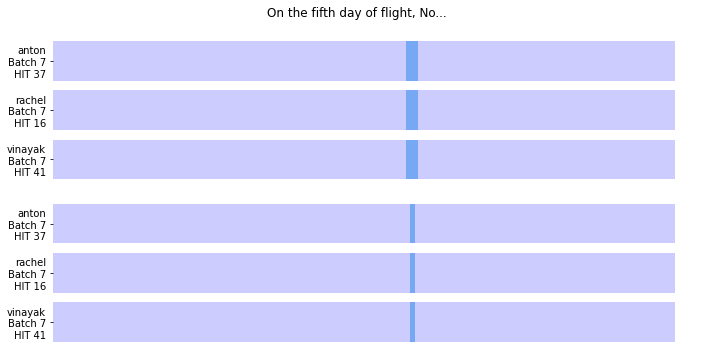

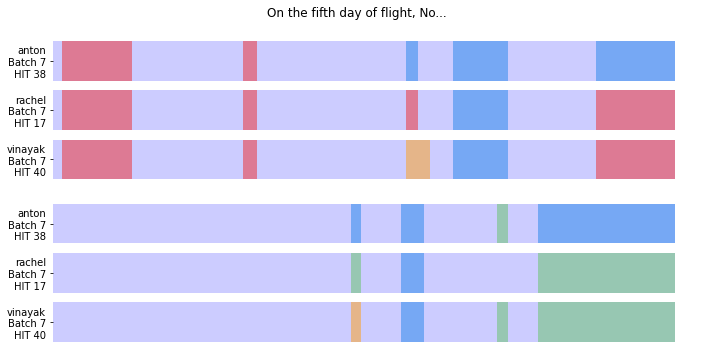

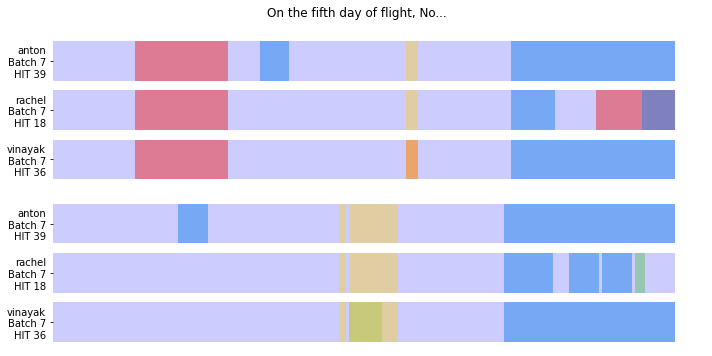

In [22]:
selected = [sent for sent in data 
    if 'Orion' in sent['original']
]
for sent_id in set([x['id'] for x in selected]):
    sents = [x for x in selected if x['id'] == sent_id]
    draw_agreement(sents)

In [23]:
for sent in set([x['simplified'] for x in selected]):
    print(sent, end='\n\n')

On November 20, 2022, at 19:09 UTC, the spacecraft entered the lunar sphere of influence and the Moon's gravity became stronger than the Earth's when the spacecraft was very close to it.

On November 20, 2022, the Orion spacecraft started to be affected by the Moon's gravity more than Earth's. || This happened at 19:09 UTC, after five days of flight.

On the fifth day of flight, November 20, 2022, at 19:09 UTC, the Orion spacecraft entered the Lunar sphere of influence, so the Moon's gravitational force became stronger than Earth's relative to the spacecraft.

On November 20, 2022 at 19:09 UTC, the Orion spacecraft began to be affected by the Moon's gravity, since it had entered the Moon's sphere of influence.

On November 20, 2022, at 19:09 UTC, the Orion spacecraft entered the Lunar sphere of influence. || This meant that the Moon was pulling the spacecraft with more gravitational force than the Earth.

On the fifth day of flight, November 20, 2022, at 19:09 UTC, the Orion spacecraft